# 构造微调训练数据集

借助 ChatGPT 和 GPT API 我们可以实现自动化批量构造训练数据集。

下面我们以中国古典哲学数据集为例，展示了自动构造训练集的主要流程：

- 使用 LangChain 构造训练数据样例
    - 基于 ChatGPT 设计 `System Role` 提示词
    - 使用 `OpenAI gpt-oss:20b` 生成基础数据
    - 解析 OpenAI GPT 生成的训练数据
    - 持久化存储`dataset.csv`训练数据集文件
    - 使用 ChatGPT 实现训练数据多样化
- 自动化批量生成训练数据集
    - 整理收集原始数据`raw_data.txt`
    - 自动解析原始数据样例 `raw_data_content[]`
    - 设计 `gen_data` 训练数据生成器函数
    - 设计训练数据生成流水线

最佳实践参考：

- 使用 GPT-4o-mini 生成基础数据：https://platform.openai.com/playground/p/2c7XNPgo6Y2iDxILiWfD3iPu?model=gpt-4o-mini&mode=chat
- 使用 ChatGPT 生成数据处理代码和相关文本整理：https://chat.openai.com/share/cdfd2d1d-a75e-4cee-be49-539c010ca1b1
- GPT API 价格: https://openai.com/pricing

## 使用 OpenAI SDk 构造训练数据

In [4]:
from openai import OpenAI
import os
from dotenv import load_dotenv
load_dotenv(override=True)

print(os.getenv("BASE_URL") )
print(os.getenv("MODEL_NAME") )


https://api.deepseek.com/v1
deepseek-chat


In [5]:
client = OpenAI(api_key= os.getenv("API_KEY"), 
                base_url=os.getenv("BASE_URL")) # 初始化OpenAI客户端，使用API密钥和基础URL, 这里使用了qwen3的API

In [29]:
response = client.chat.completions.create(
  model=os.getenv("MODEL_NAME"),
  messages=[
    {     "role": "user",
      "content": "你好，请介绍你自己。"  
    }
   ]
)

In [30]:
response.choices[0].message.content

'您好！我是 ChatGPT，OpenAI 训练的大型语言模型。我的主要功能是使用自然语言与人交流，回答问题、提供信息、帮忙写作、进行创意创作，甚至做一些简单的编程帮助。以下是我的一些特点和能力：\n\n| 特色 | 说明 |\n|------|------|\n| **多语言能力** | 除了中文，我还能使用英语、日语、法语、德语等多种语言交流。|\n| **知识截止时间** | 我的数据更新截至 2024 年 6 月，为此之前发生的事件、发布的技术和新的研究可能不在我的知识库中。|\n| **专业领域** | 但愿在编程、机械、医学、艺术、商业、教育等方面提供帮助。|\n| **创意和写作** | 我可以帮你写诗歌、小说、剧本，甚至广告文案。|\n| **情感语调** | 我能在一定程度上模拟礼貌、鼓励、安慰或轻松幽默的语气。|\n| **隐私保护** | 我不会记住您的个人信息，也不会存储对话内容。每次会话结束后，信息会被清除。|\n\n请记住，我并不是真正的“人”，也不具备独立的意识或情感，只是一个根据训练数据生成文字的程序。如果你有任何想聊的话题，随时告诉我！'

In [6]:
response = client.chat.completions.create(
  model=os.getenv("MODEL_NAME"),
  messages=[
    {
      "role": "system",
      "content": "你是中国古典哲学大师，尤其擅长周易的哲学解读。\n\n接下来，你收到的都是关于周易卦象的解释，你需要整理润色，并生成用于大模型训练的内容和格式。\n\n示例输入：\n\n师卦，此卦是异卦相叠，下卦为坎，上卦为坤。“师”指军队。坎为水、为险；坤为地、为顺，喻寓兵于农。兵凶战危，用兵乃圣人不得已而为之，但它可以顺利无阻碍地解决矛盾，因为顺乎形势，师出有名，故能化凶为吉。占得此卦，对于军事上率师出征非常有利，必无灾祸。师卦是天马出群之卦，以寡伏众之象。\n师卦位于讼卦之后，《序卦》之中这样解释道：“讼必有众起，故受之以师。师者，众也。”争讼的人越来越多，以致形成了军队。\n\n期待结果：\n\ncontent:\"师卦\"\nsummary:\"在周易中，师卦是一个极具深意的卦象，它由两个异卦相叠组成：下卦坎（水）和上卦坤（地）。这一卦象代表“师”，即军队，寓意着兵力和农力的结合。在这里，坎卦象征着水和险难，而坤卦象征着地和顺从，暗示着通过将军事力量安置于民间，可以在必要时顺利调动。\n\n师卦的核心哲学是：虽然兵力代表着危险和战争，但其使用应当是圣人不得已而为之的最后手段。在正确的情况下，军事力量可以顺应形势，将危险转化为吉祥。因此，在军事策略上，此卦象征着出征将会顺利，无灾祸。\n\n师卦紧随讼卦（争讼卦），在《序卦》中解释为“讼必有众起，故受之以师”。这意味着争端激化至众多人群的参与，形成了类似军队的集体力量。输出内容不要包含思考过程。\""
    },
    {
      "role": "user",
      "content": "蒙卦是教育启蒙的智慧，艮为山，坎为泉，山下出泉。泉水始流出山，则必将渐汇成江河,正如蒙稚渐启，又山下有险，因为有险停止不前，所以蒙昧不明。事物发展的初期阶段，必然蒙昧，所以教育是当务之急，养学生纯正无邪的品质，是治蒙之道。\n蒙卦，这个卦是异卦相叠，下卦为坎，上卦为艮。艮是山的形象，喻止；坎是水的形象，喻险。卦形为山下有险，仍不停止前进，是为蒙昧，故称蒙卦。但因把握时机，行动切合时宜;因此，具有启蒙和通达的卦象。\n《蒙》卦是《屯》卦这个始生卦之后的第二卦。《序卦》中说：“物生必蒙，故受之以蒙。蒙者，蒙也，特之稚也。”物之幼稚阶段，有如蒙昧未开的状态，在人则是指童蒙。\n《象》中这样解释蒙卦：山下出泉，蒙；君子以果行育德。"
    },
    {
      "role": "assistant",
      "content": "content:\"蒙卦\"\nsummary:\"在周易中，蒙卦象征着教育启蒙和智慧的初期阶段，由两个异卦相叠组成：下卦坎（水）和上卦艮（山）。坎象征水，艮象征山，代表了山下有水源，水流出山。这预示着在事物发展的起初阶段，人们会陷入蒙昧状态，因此教育成为当务之急。只有培养纯正无邪的品质，才能走上通达之路，如同泉水汇成江河。\n\n蒙卦的核心哲学是：事物发展的初期阶段必然处于蒙昧状态，但如果能把握时机，行动切合时宜，就能启蒙通达。蒙卦紧随始生卦《屯》之后，《序卦》中解释道：“物生必蒙，故受之以蒙。蒙者，蒙也，特之稚也。”这说明物在幼稚阶段都会经历蒙昧状态，找它蒙即是稚嫩。\n\n《象》中解释说：山下出泉，蒙；君子以果行育德，意味着像泉水从山下流出一样，启蒙教育有助于培育美德。输出内容不要包含思考过程。\""
    },
    {
      "role": "user",
      "content": "需卦，本卦是异卦相叠，上卦为坎，下卦为乾。乾卦象征天空辽阔，坎卦象征乌云密布。雨水之于传统农业社会而言，是最大的需求，因此用这个意象来表现。古人引申为雨将下，万物皆待，所以叫需。\n需，古体字结构是“雨上天下”，从雨而声。如苍天下雨，滋养万物及人。从人的角度看，天下雨，则不易出行耕作，因此在家喝酒吃肉、静待天时。所以，这一卦的基本象征就是等待、不进，还有饮食之义。\n \n需卦位于蒙卦之后，《序卦》之中这样解释道：“物稚不可不养也，故受之以需。需者，饮食之道也。”有所需要，也是有所等待。\n《象》曰：云上于天，需;君子以饮食宴乐。\n《象》中这段话的意思是说：需卦的卦象是乾(天)下坎(水)上，为水在天上之表象。水汽聚集天上成为云层，密云満天，但还没有下雨，需要等待;君子在这个时候需要吃喝，饮酒作乐，即在等待的时候积蓄力量。\n需卦象征等待，启示人们守正待机的道理，属于中上卦。《象》这样评断此卦：明珠土埋日久深，无光无亮到如今，忽然大风吹土去，自然显露有重新。\n"
    },
    {
      "role": "assistant",
      "content": "content:\"需卦\"\nsummary:\"在周易中，需卦是一个富有深意的卦象，由两个异卦相叠组成：下卦乾（天）和上卦坎（水）。乾象征广阔的天空，而坎象征乌云密布，暗示着迫切需要雨水的意象。古人将雨水视为万物生长的必需，因此命名为“需”。需卦的基本象征是等待和饮食之道。\n\n需卦位于蒙卦之后，《序卦》中解释为“物稚不可不养也，故受之以需。需者，饮食之道也。”说明物在幼稚状态需要得到滋养，因此受到需卦的启示。《象》中描述：云上于天，需；君子以饮食宴乐。意味着天空乌云密布，需要等待雨水，而君子则在等待的过程中积蓄力量，享受饮食和欢乐。\n\n需卦的核心哲学是：等待，启示着守正待机的道理。它属于中上卦，象征着埋藏已久的明珠，经过大风吹去尘埃后，重新显露光芒。输出内容不要包含思考过程。\""
    }
  ],
  temperature=1,
  max_tokens=4095,
  top_p=1,
  frequency_penalty=0,
  presence_penalty=0
)

---

## 使用 LangChain 构造训练数据

In [7]:
from langchain.chat_models import ChatOpenAI
from langchain.schema import HumanMessage, SystemMessage
from langchain.prompts.chat import (
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
    SystemMessagePromptTemplate,
)

chat = ChatOpenAI(model=os.getenv("MODEL_NAME"),
                  api_key=os.getenv("API_KEY"),
                  base_url=os.getenv("BASE_URL"),
                  temperature=1,
                  max_tokens=4095)

/home/wangfuxin/.local/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(


In [8]:
system_content = """
你是中国古典哲学大师，尤其擅长周易的哲学解读。

接下来，你收到的都是关于周易卦象的解释，你需要整理润色，并生成用于大模型训练的内容和格式。

示例输入：

师卦，此卦是异卦相叠，下卦为坎，上卦为坤。“师”指军队。坎为水、为险；坤为地、为顺，喻寓兵于农。兵凶战危，用兵乃圣人不得已而为之，但它可以顺利无阻碍地解决矛盾，因为顺乎形势，师出有名，故能化凶为吉。占得此卦，对于军事上率师出征非常有利，必无灾祸。师卦是天马出群之卦，以寡伏众之象。
师卦位于讼卦之后，《序卦》之中这样解释道：“讼必有众起，故受之以师。师者，众也。”争讼的人越来越多，以致形成了军队。

期待结果：

content:"师卦"
summary:"在周易中，师卦是一个极具深意的卦象，它由两个异卦相叠组成：下卦坎（水）和上卦坤（地）。这一卦象代表“师”，即军队，寓意着兵力和农力的结合。在这里，坎卦象征着水和险难，而坤卦象征着地和顺从，暗示着通过将军事力量安置于民间，可以在必要时顺利调动。

师卦的核心哲学是：虽然兵力代表着危险和战争，但其使用应当是圣人不得已而为之的最后手段。在正确的情况下，军事力量可以顺应形势，将危险转化为吉祥。因此，在军事策略上，此卦象征着出征将会顺利，无灾祸。

师卦紧随讼卦（争讼卦），在《序卦》中解释为“讼必有众起，故受之以师”。这意味着争端激化至众多人群的参与，形成了类似军队的集体力量。"

请输出内容不要包含思考过程。
"""


In [9]:
# 原始数据
raw_content = "蒙卦是教育启蒙的智慧，艮为山，坎为泉，山下出泉。泉水始流出山，则必将渐汇成江河,正如蒙稚渐启，又山下有险，因为有险停止不前，所以蒙昧不明。事物发展的初期阶段，必然蒙昧，所以教育是当务之急，养学生纯正无邪的品质，是治蒙之道。\n蒙卦，这个卦是异卦相叠，下卦为坎，上卦为艮。艮是山的形象，喻止；坎是水的形象，喻险。卦形为山下有险，仍不停止前进，是为蒙昧，故称蒙卦。但因把握时机，行动切合时宜;因此，具有启蒙和通达的卦象。\n《蒙》卦是《屯》卦这个始生卦之后的第二卦。《序卦》中说：“物生必蒙，故受之以蒙。蒙者，蒙也，特之稚也。”物之幼稚阶段，有如蒙昧未开的状态，在人则是指童蒙。\n《象》中这样解释蒙卦：山下出泉，蒙；君子以果行育德。"

In [10]:
messages = [
    SystemMessage(
        content=system_content
    ),
    HumanMessage(
        content=raw_content
    ),
]

In [11]:
ai_message = chat(messages)

/home/wangfuxin/.local/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `BaseChatModel.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


### 解析 OpenAI GPT 生成的训练数据

In [12]:
ai_message.content

'content:"蒙卦"\nsummary:"在周易中，蒙卦象征着启蒙和教育，由两个异卦相叠组成：下卦坎（水）和上卦艮（山）。这一卦象代表“蒙”，即蒙昧和初始阶段，寓意着事物发展初期的蒙稚状态。在这里，艮卦象征着山和停止，坎卦象征着水和险难，形成山下出泉的景象，暗示泉水始流却因险阻而停滞，正如蒙昧不明需要引导。\n\n蒙卦的核心哲学是：在事物萌芽时期，必然存在蒙昧和无知，因此教育成为至关重要的手段。通过培养纯正无邪的品质，可以开启智慧，化险为夷。卦象强调把握时机和行动切合时宜，从而带来启蒙和通达的结果。\n\n蒙卦紧随屯卦（始生卦），在《序卦》中解释为“物生必蒙，故受之以蒙。蒙者，蒙也，特之稚也”，意指万物诞生后必经历幼稚蒙昧阶段，在人则指童蒙时期。《象》中进一步阐释：“山下出泉，蒙；君子以果行育德”，鼓励以果断行动培育德行，以应对初始的蒙昧挑战。"'

In [13]:
text = ai_message.content

# 分割字符串来找到content和summary的位置
content_start = text.find('content:"') + len('content:"')
content_end = text.find('"\nsummary:')
summary_start = text.find('summary:"') + len('summary:"')
summary_end = text.rfind('"')

# 提取并存储content和summary
content = text[content_start:content_end].strip()
summary = text[summary_start:summary_end].strip()

print("Content:", content)
print("Summary:", summary)


Content: 蒙卦
Summary: 在周易中，蒙卦象征着启蒙和教育，由两个异卦相叠组成：下卦坎（水）和上卦艮（山）。这一卦象代表“蒙”，即蒙昧和初始阶段，寓意着事物发展初期的蒙稚状态。在这里，艮卦象征着山和停止，坎卦象征着水和险难，形成山下出泉的景象，暗示泉水始流却因险阻而停滞，正如蒙昧不明需要引导。

蒙卦的核心哲学是：在事物萌芽时期，必然存在蒙昧和无知，因此教育成为至关重要的手段。通过培养纯正无邪的品质，可以开启智慧，化险为夷。卦象强调把握时机和行动切合时宜，从而带来启蒙和通达的结果。

蒙卦紧随屯卦（始生卦），在《序卦》中解释为“物生必蒙，故受之以蒙。蒙者，蒙也，特之稚也”，意指万物诞生后必经历幼稚蒙昧阶段，在人则指童蒙时期。《象》中进一步阐释：“山下出泉，蒙；君子以果行育德”，鼓励以果断行动培育德行，以应对初始的蒙昧挑战。


### 持久化存储训练数据集文件

In [14]:
import csv

# 如果没有GPT API，可以使用预定义的变量
# content = "蒙卦"
# summary = "在周易中，师卦是一个极具深意的卦象，它由两个异卦相叠组成：下卦坎（水）和上卦坤（地）。这一卦象代表“师”，即军队，寓意着兵力和农力的结合。在这里，坎卦象征着水和险难，而坤卦象征着地和顺从，暗示着通过将军事力量安置于民间，可以在必要时顺利调动。师卦的核心哲学是：虽然兵力代表着危险和战争，但其使用应当是圣人不得已而为之的最后手段。在正确的情况下，军事力量可以顺应形势，将危险转化为吉祥。因此，在军事策略上，此卦象征着出征将会顺利，无灾祸。师卦紧随讼卦（争讼卦），在《序卦》中解释为“讼必有众起，故受之以师”。这意味着争端激化至众多人群的参与，形成了类似军队的集体力量。"

# 新建CSV文件并写入数据
with open('test_dataset.csv', mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    # 写入标题行
    writer.writerow(['content', 'summary'])
    # 写入数据行
    writer.writerow([content, summary])


### 数据增强：构造多样化的提问方式

In [15]:
def generate_question_summary_pairs(content, summary):
    """
    生成20对提问和总结的配对。

    :param content: 内容（例如：“蒙卦”）。
    :param summary: 内容的总结。
    :return: 包含20对提问和总结的列表。
    """
    # 20种提问模板
    question_templates = [
        "{}代表什么？",
        "周易中的{}含义是什么？",
        "请解释一下{}。",
        "{}在周易中是什么象征？",
        "周易{}的深层含义是什么？",
        "{}和教育启蒙有什么联系？",
        "周易的{}讲述了什么？",
        "{}是怎样的一个卦象？",
        "{}在周易中怎样表达教育的概念？",
        "{}的基本意义是什么？",
        "周易中{}的解释是什么？",
        "{}在周易中代表了哪些方面？",
        "{}涉及哪些哲学思想？",
        "周易中{}的象征意义是什么？",
        "{}的主要讲述内容是什么？",
        "周易{}的核心思想是什么？",
        "{}和启蒙教育之间有何联系？",
        "在周易中，{}象征着什么？",
        "请描述{}的含义。",
        "{}在周易哲学中扮演什么角色？"
    ]

    # 使用content填充提问模板
    questions = [template.format(content) for template in question_templates]

    # 创建提问和总结的配对
    question_summary_pairs = [(question, summary) for question in questions]

    return question_summary_pairs

In [16]:
import csv

# 如果没有GPT API，可以使用预定义的变量
# content = "蒙卦"
# summary = "在周易中，师卦是一个极具深意的卦象，它由两个异卦相叠组成：下卦坎（水）和上卦坤（地）。这一卦象代表“师”，即军队，寓意着兵力和农力的结合。在这里，坎卦象征着水和险难，而坤卦象征着地和顺从，暗示着通过将军事力量安置于民间，可以在必要时顺利调动。师卦的核心哲学是：虽然兵力代表着危险和战争，但其使用应当是圣人不得已而为之的最后手段。在正确的情况下，军事力量可以顺应形势，将危险转化为吉祥。因此，在军事策略上，此卦象征着出征将会顺利，无灾祸。师卦紧随讼卦（争讼卦），在《序卦》中解释为“讼必有众起，故受之以师”。这意味着争端激化至众多人群的参与，形成了类似军队的集体力量。"
pairs = generate_question_summary_pairs(content, summary)

# 将结果写入CSV文件
with open('test_dataset.csv', mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(['content', 'summary'])
    for pair in pairs:
        writer.writerow(pair)


## 自动化批量生成训练数据流水线

原始数据来源：https://www.zhouyi.cc/zhouyi/yijing64/4103.html

In [17]:
# 初始化一个空列表用于存储原始内容数据
raw_content_data = []

# 读取文件并分割数据样例
with open('data/raw_data.txt', 'r', encoding='utf-8') as file:
    content = file.read()
    # 使用连续的换行符('\n\n')作为分隔符来分割文本
    data_samples = content.split('\n\n')

    # 遍历分割后的数据样例并添加到列表中
    for sample in data_samples:
        # 移除每个样例中的额外空白字符（如果有的话）
        cleaned_sample = sample.strip()
        # 仅添加非空样例
        if cleaned_sample:
            raw_content_data.append(cleaned_sample)

In [18]:
# 输出结果以验证
for i, sample in enumerate(raw_content_data[:5]):  # 打印前5个样例以检查
    print(f"样例 {i+1}:")
    print(sample)
    print("------")


样例 1:
蒙卦原文
蒙。亨。匪我求童蒙，童蒙求我。初筮告，再三渎，渎则不告。利贞。
象曰：山下出泉，蒙。君子以果行育德。
白话文解释
蒙卦：通泰。不是我有求于幼稚愚昧的人，而是幼稚愚昧的人有求于我。第一次占筮，神灵告诉了他。轻慢不敬的再三占筮，轻慢不敬的占筮，神灵就不会告诉他。但还是吉利的卜问。
《象辞》说：上卦为艮，象征山；下卦为坎，象征泉。山下有泉，泉水喷涌而出，这是蒙卦的卦象。君子观此卦象，取法于一往无前的山泉，从而以果敢坚毅的行动来培养自身的品德。
《断易天机》解
蒙卦艮上坎下，为离宫四世卦。蒙即蒙昧，主回还往复，疑惑不前，多忧愁过失，乃是凶卦。
北宋易学家邵雍解
智慧未开，蒙昧闭塞；犹豫不决，缺乏果断。
得此卦者，智慧犹如童蒙，不辨是非，迷失方向；若能顺贤师良友之教，启其聪明则亨通。
台湾国学大儒傅佩荣解
时运：蓄积德行，出而用世。
财运：矿山生意，果决则吉。
家宅：君子居吉；婚姻之始。
身体：驱去邪热，可保平安。
传统解卦
这个卦是异卦（下坎上艮）相叠，艮是山的形象，喻止；坎是水的形象，喻险。卦形为山下有险，仍不停止前进，是为蒙昧，故称蒙卦。但因把握时机，行动切合时宜，因此，具有启蒙和通达的卦象。
大象：蒙者，昏而无所见也，故宜「启蒙」。
运势：初时迷惑不知方向，须忍耐待机而动，凡事多听取别人意见，则运可通。
事业：事业开始，混乱无序，危机四伏，以勇敢坚毅的行动可以扭转局面。然而必须接受严格教育，培养这种奋发图强的精神。务必脚踏实地，最忌好高骛远，否则会陷入孤立无援的境地。
经商：务必小心谨慎，不得急功近利，尤其应树立高尚的商业道德，以良好的信誉提高竞争力而取胜。
求名：必须接受良好的基础教育，陶冶情操。且动机纯正，可以达到目的。
婚恋：注意考察对方品德，不可以金钱为诱铒。夫妻需相互宽容、理解。
决策：有时会陷入迷惘困顿的境地，加上胆小、不果断，往往误事。如能接受长辈的教诲，甚至严酷的考验，抛弃疑惧的心理，等待适当时机，必然一帆风顺。
------
样例 2:
屯卦原文
屯。元，亨，利，贞。勿用，有攸往，利建侯。
象曰：云，雷，屯；君子以经纶。
白话文解释
屯卦。大吉大利，吉利的占卜。不利于出门。有利于建国封侯。
《象辞》说：屯的上卦为坎，坎为云，下卦为震，震为雷。云行于上，雷动于下，是屯卦的卦象。君子观此卦象，取法于云雷，用云的恩泽，雷的威严来治理国

### 将以上的所有模块，整合到一起，自动化生成数据

In [19]:
from langchain.chat_models import ChatOpenAI
from langchain.schema import HumanMessage, SystemMessage
from langchain.prompts.chat import (
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
    SystemMessagePromptTemplate,
)

# 初始化LangChain的deepseek调用
chat = ChatOpenAI(model=os.getenv("MODEL_NAME"),
                  api_key=os.getenv("API_KEY"),
                  base_url=os.getenv("BASE_URL"),
                  temperature=1,
                  max_tokens=4095)

def gen_data(raw_content):
    """
    使用LangChain GPT-4o-mini调用处理单个数据样例。

    :param raw_content: 原始数据样例。
    :return: GPT-4o-mini模型生成的内容。
    """
    # 系统消息定义背景和任务
    system_message = SystemMessage(
        content="""
        你是中国古典哲学大师，尤其擅长周易的哲学解读。

        接下来，你收到的都是关于周易卦象的解释，你需要整理润色，并生成用于大模型训练的内容和格式。

        示例输入：

        师卦，此卦是异卦相叠，下卦为坎，上卦为坤。“师”指军队。坎为水、为险；坤为地、为顺，喻寓兵于农。兵凶战危，用兵乃圣人不得已而为之，但它可以顺利无阻碍地解决矛盾，因为顺乎形势，师出有名，故能化凶为吉。占得此卦，对于军事上率师出征非常有利，必无灾祸。师卦是天马出群之卦，以寡伏众之象。
        师卦位于讼卦之后，《序卦》之中这样解释道：“讼必有众起，故受之以师。师者，众也。”争讼的人越来越多，以致形成了军队。

        期待结果：

        content:"师卦"
        summary:"在周易中，师卦是一个极具深意的卦象，它由两个异卦相叠组成：下卦坎（水）和上卦坤（地）。这一卦象代表“师”，即军队，寓意着兵力和农力的结合。在这里，坎卦象征着水和险难，而坤卦象征着地和顺从，暗示着通过将军事力量安置于民间，可以在必要时顺利调动。

        师卦的核心哲学是：虽然兵力代表着危险和战争，但其使用应当是圣人不得已而为之的最后手段。在正确的情况下，军事力量可以顺应形势，将危险转化为吉祥。因此，在军事策略上，此卦象征着出征将会顺利，无灾祸。

        师卦紧随讼卦（争讼卦），在《序卦》中解释为“讼必有众起，故受之以师”。这意味着争端激化至众多人群的参与，形成了类似军队的集体力量。"
        """
    )

    # 人类消息包含原始数据样例
    human_message = HumanMessage(
        content=raw_content
    )

    # 构建消息列表并进行模型调用
    messages = [system_message, human_message]
    ai_message = chat(messages)

    return ai_message.content

In [24]:
# 示例调用（使用 raw_data.txt 中解析的数据样例）
generated_content = gen_data(raw_content_data[0])
print(generated_content)

content:"蒙卦"
summary:"在周易哲学体系中，蒙卦（䷃）象征着启蒙与成长，由下卦坎（水）与上卦艮（山）组成，形成“山下出泉”之象，寓意智慧如泉水般需突破蒙昧而涌流。卦辞强调“亨通”，并指出并非智者主动寻求蒙昧者，而是蒙昧者主动求教于智者——首次诚心问询可得启示，若轻慢重复则失其真谛，但坚守正道（利贞）终得吉祥。

从象辞视角，君子观察此卦，应以果敢之行培育德性，如山泉般坚定向前。然而，《断易天机》警示此卦主回还疑惑、多忧愁过失，属凶兆，反映人性在未开明时的徘徊与风险。邵雍解为“智慧未开，蒙昧闭塞”，需借贤师之导引方能通达；傅佩荣则从实用角度析其时运、财运与家宅，强调蓄德、果决与初心之重。

传统解卦深化其二元性：山下有险（坎险遇艮止），却不止前进，喻示虽处蒙昧却因时机把握而启蒙。运势初迷需忍耐听谏，事业始乱需勇敢行动与脚踏实地，经商求名皆重道德基础，婚恋需察品徳非物欲，决策则须弃疑惧、受考验以待时机。整体而言，蒙卦揭示人类从混沌至明觉的哲学旅程：通过教育、自省与果毅，转化蒙蔽为通达。"


In [25]:
def dataset_parser(ai_message_content):
    """
    解析由gen_data函数生成的ai_message.content，提取content和summary。

    :param ai_message_content: gen_data函数返回的文本。
    :return: 提取的content和summary。
    """
    # 分割字符串来找到content和summary的位置
    content_start = ai_message_content.find('content:"') + len('content:"')
    content_end = ai_message_content.find('"\nsummary:')
    summary_start = ai_message_content.find('summary:"') + len('summary:"')
    summary_end = ai_message_content.rfind('"')

    # 提取并存储content和summary
    content = ai_message_content[content_start:content_end].strip()
    summary = ai_message_content[summary_start:summary_end].strip()

    return content, summary


In [26]:
# 示例调用（使用假设的gen_data函数返回的文本）
content, summary = dataset_parser(generated_content)
print("Content:", content)
print("Summary:", summary)

Content: 蒙卦
Summary: 在周易哲学体系中，蒙卦（䷃）象征着启蒙与成长，由下卦坎（水）与上卦艮（山）组成，形成“山下出泉”之象，寓意智慧如泉水般需突破蒙昧而涌流。卦辞强调“亨通”，并指出并非智者主动寻求蒙昧者，而是蒙昧者主动求教于智者——首次诚心问询可得启示，若轻慢重复则失其真谛，但坚守正道（利贞）终得吉祥。

从象辞视角，君子观察此卦，应以果敢之行培育德性，如山泉般坚定向前。然而，《断易天机》警示此卦主回还疑惑、多忧愁过失，属凶兆，反映人性在未开明时的徘徊与风险。邵雍解为“智慧未开，蒙昧闭塞”，需借贤师之导引方能通达；傅佩荣则从实用角度析其时运、财运与家宅，强调蓄德、果决与初心之重。

传统解卦深化其二元性：山下有险（坎险遇艮止），却不止前进，喻示虽处蒙昧却因时机把握而启蒙。运势初迷需忍耐听谏，事业始乱需勇敢行动与脚踏实地，经商求名皆重道德基础，婚恋需察品徳非物欲，决策则须弃疑惧、受考验以待时机。整体而言，蒙卦揭示人类从混沌至明觉的哲学旅程：通过教育、自省与果毅，转化蒙蔽为通达。


In [27]:
import csv
import datetime
import os

def main():
    # 确保 data 目录存在
    if not os.path.exists('data'):
        os.makedirs('data')

    # 解析 data/raw_data.txt 得到 raw_content_data 列表
    raw_content_data = []
    with open('data/raw_data.txt', 'r', encoding='utf-8') as file:
        content = file.read()
        data_samples = content.split('\n\n')
        for sample in data_samples:
            cleaned_sample = sample.strip()
            if cleaned_sample:
                raw_content_data.append(cleaned_sample)

    # 创建带有时间戳的CSV文件名
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"data/zhouyi_dataset_{timestamp}.csv"

    # 创建CSV文件并写入标题行
    with open(filename, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(['content', 'summary'])

        # 循环遍历 raw_content_data 数据样例
        for raw_content in raw_content_data:
            # 调用 gen_data 方法得到 ai_message_content
            ai_message_content = gen_data(raw_content)

            # 解析 ai_message_content 得到 content 和 summary
            content, summary = dataset_parser(ai_message_content)
            
            print("Content:", content)
            print("Summary:", summary)

            # 调用 generate_question_summary_pairs 得到20组 pairs
            pairs = generate_question_summary_pairs(content, summary)

            # 将 pairs 写入 csv 文件
            for pair in pairs:
                writer.writerow(pair)


In [21]:
# 执行主函数
main()

Content: 蒙卦
Summary: 在周易中，蒙卦（䷃）由下卦坎（水）和上卦艮（山）组成，象征山下出泉之象，代表着启蒙、蒙昧与教育。卦辞强调“亨通”，并指出不是智者主动寻求蒙昧者，而是蒙昧者主动求教于智者。初次占问可获得启示，但若反复轻慢占问（渎），则不再得到回应。此卦总体利于坚守正道（利贞）。

蒙卦的核心哲学在于：人生或事业初期常处于蒙昧未开的状态，需要外在的引导与教育来启发智慧。君子观此卦象，应效法山泉果决前行的特性，以坚毅行动培育德性。邵雍解此卦为“智慧未开，犹豫不决”，傅佩荣则从时运、财运等角度指出需积蓄德行、果决行事。

传统解卦认为，蒙卦虽象征危险（坎）与阻碍（艮），但若能把握时机、接受教育，即可转蒙为明。在事业、经商、求名等方面，此卦强调启蒙的重要性——需脚踏实地、接受指导，而非急功近利。婚恋方面重在考察品德，决策则需克服犹豫、借助长辈教诲。

值得注意的是，《断易天机》视蒙卦为凶卦，主“疑惑不前，多忧愁过失”，这提醒我们：蒙昧若不加以教化，易陷于困顿。但总体而言，蒙卦更强调通过教育与自律实现从蒙到通的转变。
Content: 屯卦
Summary: 在周易中，屯卦象征着万物初生时的艰难与潜力，卦辞为'元，亨，利，贞。勿用，有攸往，利建侯'，寓意创始阶段虽充满挑战，但坚守正道最终能获得吉祥和成功。此卦由下震（雷）和上坎（水）组成，雷雨交加，代表动中有险，环境恶劣却孕育生机。

屯卦的核心哲学是：事物在初始阶段常伴随困难与阻碍，需要坚毅不拔和谨慎行动。君子观此卦象，应效法云雷之象，以恩泽与威严并济的方式处理事务，治理国事或人生挑战。邵雍解为'万物始生，开始困难；先劳后逸，苦尽甘来'，强调守成而非冒进，通过努力排除万难，终将苦尽甘来。

在运势上，屯卦提示身处困境时宜步步为营，事业和经商需知难而进，灵活应对，初期多有挫折但坚持可获大成。婚恋方面，好事多磨，忠贞与大胆追求能带来美满结果。整体上，此卦教导人们面对初生之艰，应以乐观和毅力迎接挑战，借助他人之助突破孤独，实现通达。
Content: 需卦
Summary: 在周易哲学中，需卦（䷄）由下乾上坎组成，乾象征天与刚健，坎象征水与险陷，形成“云上于天”的意象，代表等待和期待。卦辞“有孚，光亨，贞吉。利涉大川”强调诚信、光明通达和坚守正道的重要性，预示克服重大险阻的有利前景。

需卦的核心哲学是：面

#### 本地模型运行时，Ollama利用了GPU算力和显存

占用约13GB显存

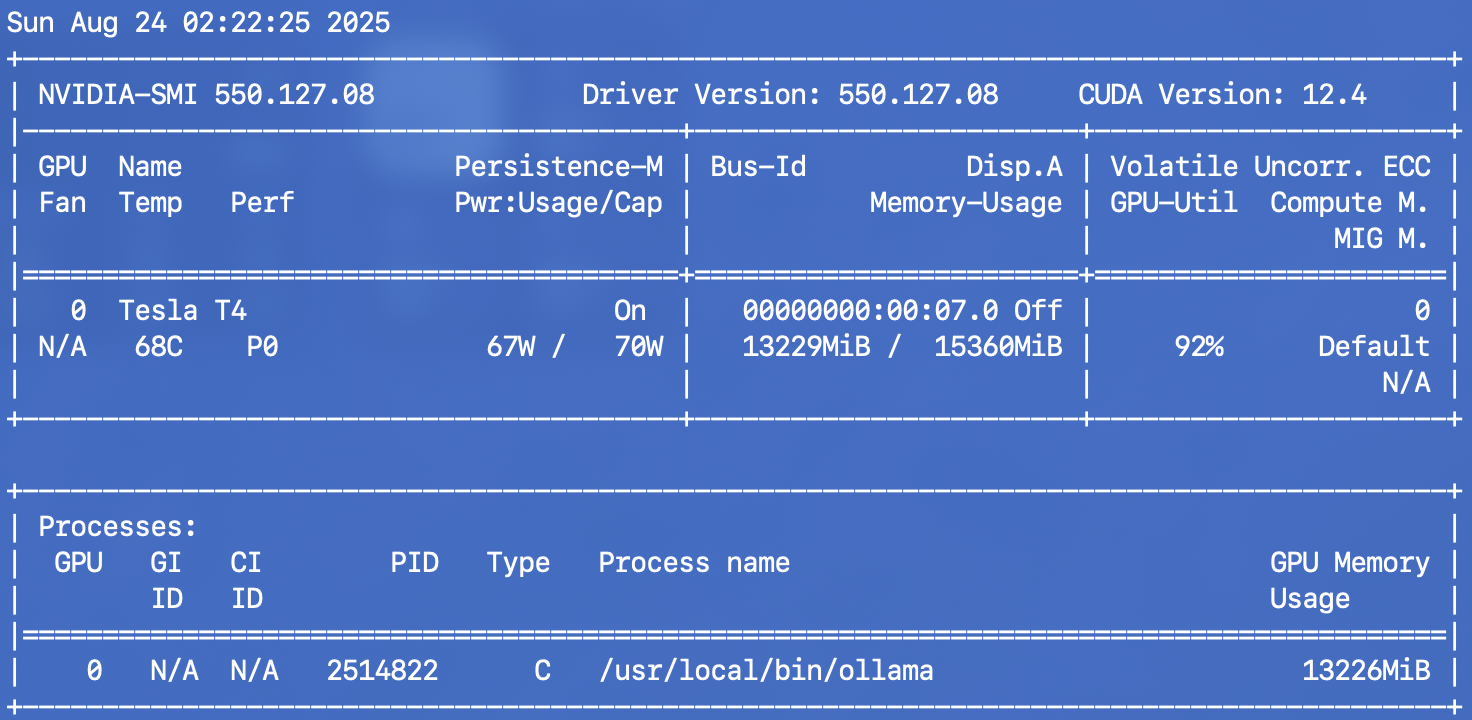

### 异常分析


训练第一个 epoch 时，Training Loss 比较奇怪：

```
Step	Training Loss
1	4.374600
2	4.594300
3	4.470600
4	4.597700
5	4.432100
6	4.302500
7	4.131100
8	4.084700
```


In [28]:
def gen_data(raw_content):
    """
    使用LangChain qwen3:4b调用处理单个数据样例。

    :param raw_content: 原始数据样例。
    :return: qwen3:4b模型生成的内容。
    """
    # 系统消息定义背景和任务
    system_message = SystemMessage(
        content="""
        你是中国古典哲学大师，尤其擅长周易的哲学解读。

        接下来，你收到的都是关于周易卦象的解释，你需要整理润色，并生成用于大模型训练的内容和格式。

        示例输入：

        师卦，此卦是异卦相叠，下卦为坎，上卦为坤。“师”指军队。坎为水、为险；坤为地、为顺，喻寓兵于农。兵凶战危，用兵乃圣人不得已而为之，但它可以顺利无阻碍地解决矛盾，因为顺乎形势，师出有名，故能化凶为吉。占得此卦，对于军事上率师出征非常有利，必无灾祸。师卦是天马出群之卦，以寡伏众之象。
        师卦位于讼卦之后，《序卦》之中这样解释道：“讼必有众起，故受之以师。师者，众也。”争讼的人越来越多，以致形成了军队。

        期待结果：

        content:"师卦"
        summary:"在周易中，师卦是一个极具深意的卦象，它由两个异卦相叠组成：下卦坎（水）和上卦坤（地）。这一卦象代表“师”，即军队，寓意着兵力和农力的结合。在这里，坎卦象征着水和险难，而坤卦象征着地和顺从，暗示着通过将军事力量安置于民间，可以在必要时顺利调动。

        师卦的核心哲学是：虽然兵力代表着危险和战争，但其使用应当是圣人不得已而为之的最后手段。在正确的情况下，军事力量可以顺应形势，将危险转化为吉祥。因此，在军事策略上，此卦象征着出征将会顺利，无灾祸。

        师卦紧随讼卦（争讼卦），在《序卦》中解释为“讼必有众起，故受之以师”。这意味着争端激化至众多人群的参与，形成了类似军队的集体力量。"

        返回格式要求：
        content:"{卦名}"
        summary:"{内容}"
        """
    )

    # 人类消息包含原始数据样例
    human_message = HumanMessage(
        content=raw_content
    )

    # 构建消息列表并进行模型调用
    messages = [system_message, human_message]
    ai_message = chat(messages)

    return ai_message.content

In [29]:
# 执行主函数
main()

Content: 蒙卦
Summary: 在周易中，蒙卦象征着启蒙与成长，由下卦坎（水）和上卦艮（山）组成，形成“山下出泉”之象。这一卦象代表初始的蒙昧状态，如同泉水从山间涌出，需引导与教化方能明晰方向。卦辞强调“匪我求童蒙，童蒙求我”，突显主动求教的重要性，而非被动等待启示。初次占问可得答案，但若轻慢重复（“再三渎”），则将失去指引，唯有坚守正道（“利贞”）方可通达。

蒙卦的核心哲学在于：智慧未开之时，人易陷入犹豫与困惑，但通过接受教育、培养德行，能逐步摆脱蒙昧。君子观此卦象，应以果敢行动育德，如泉水般一往无前。运势上，初时多迷惘，需忍耐待机，听取他人意见；事业与经商则强调脚踏实地、谨慎行事，不可急功近利。

传统解卦指出，蒙卦虽主凶（多忧愁过失），但若能把握时机、顺贤师之教，可转危为安。婚恋需重品德而非物质，决策则需克服胆怯，接受考验。整体而言，蒙卦是启蒙之始，寓意通过努力与教化，从混沌走向光明。
Content: 屯卦
Summary: 在周易中，屯卦象征着万物初生时的艰难与潜力，卦辞'元亨利贞'揭示其虽具创始通达之德，却需谨慎行事('勿用有攸往')，而'利建侯'则暗喻在困境中奠定基业的重要性。卦象上坎（水云）下震（雷），云雷交动，展现初生之际的动态与险阻，君子由此领悟以恩泽与威严并济的方式治理事务。

传统解读强调，屯卦代表事物发端阶段的挑战，如雷雨交加般险象环生，但顺应天时便能焕发生机。邵雍指出'万物始生，开始困难'，傅佩荣则从实际角度补充：时运宜守、财运维艰、家宅需修、身体重元气。整体运势提示身处逆境时需步步为营，通过坚忍、果敢和外部援助化解初难，终得甘来。

在事业与经商中，此卦倡导知难而进、灵活应变，但避免冒进；婚恋方面虽多磨却终成美满；决策时依赖毅力与乐观，并借贤德之助突破孤独困局。屯卦的核心哲学在于：初始的阻碍是成长必经之过程，唯有经纶世事，方能化险为夷，迎来欣欣向荣。
Content: 需卦
Summary: 在周易中，需卦是一个富有哲理的卦象，由下卦乾（天）和上卦坎（水）组成，象征着云浮于天、待时而雨的意境。卦辞“有孚，光亨，贞吉。利涉大川”强调诚信、光明通达和坚守正道的重要性，预示吉祥和克服重大困难的能力。

需卦的核心哲学是等待与时机。它提醒人们，当面对险阻（坎卦）时，应以刚健（乾卦）但谨慎的态度应对，不可冒进。君子观此卦象，应学会在适

#### 尝试过deepseek:8b,qwen3:4b和gpt-oss:20b三个本地大模型，均调用本机ollama部署，效果最好还是gtp-oss,能够更好理解提示词要求，并按格式输出Content和Summary。生成的数据冗余信息少，用时也最少。但是本地小参数规模的模型结果均不如线上deepseek V3.1版本结果好。